In [10]:
import boto3
import pandas as pd
import numpy as np
import sqlalchemy
import pyodbc
from datetime import datetime
from pandas.tseries.offsets import MonthEnd
from datetime import timedelta
import matplotlib.pyplot as plt
from functools import reduce

df = pd.read_json('credentials.json')
AWS_ACCESS_KEY_ID = df['data_sources']['s3']['creds']['aws_access_key_id']
AWS_SECRET_ACCESS_KEY_ID = df['data_sources']['s3']['creds']['aws_secret_access_key']
BUCKET = df['data_sources']['s3']['bucket']
KEY_LOSER=df['data_sources']['s3']['folder_path_Loser']
KEY_LOST=df['data_sources']['s3']['folder_path_Lost']
RED_SHIFT_USER_NAME= df['data_sources']['redshift']['creds']['username']
RED_SHIFT_PASSWORD= df['data_sources']['redshift']['creds']['password']
RED_SHIFT_HOST= df['data_sources']['redshift']['creds']['host']
RED_SHIFT_PORT= df['data_sources']['redshift']['creds']['port']
RED_SHIFT_DATABASE= df['data_sources']['redshift']['creds']['database']

# s3_Connection


In [2]:

class s3_connection:

    def __init__(self, awsAccessKeyId,awsSecretAccessKey, bucketName,key):
        self.awsAccessKeyId = awsAccessKeyId
        self.awsSecretAccessKey = awsSecretAccessKey
        self.bucketName = bucketName
        self.key = key

    def create_s3_connection(self):
            s3_client = boto3.client("s3",
                        aws_access_key_id=self.awsAccessKeyId,
                        aws_secret_access_key=self.awsSecretAccessKey)
           
            response = s3_client.get_object(Bucket=f'{self.bucketName}', Key=f'{self.key}')
            dataframe = pd.read_csv(response.get("Body"),header=3)
       
            return dataframe


# red_Shift_Connection 

In [3]:
class redshift_connection:

    def __init__(self, username,password,host,port,database,query):
        self.username = username
        self.password = password
        self.host = host 
        self.port = port 
        self.database = database 
        self.query = query
        

    def create_redshift_connection(self):
            db=sqlalchemy.create_engine('redshift+psycopg2://'f'{self.username}:'f'{self.password}@'f'{self.host}:'f'{self.port}/'f'{self.database}')
            dataframe =pd.read_sql(f'{self.query}', con=db)
            return dataframe
        
    def migrate_data_to_redshift(self):
            con=sqlalchemy.create_engine('postgresql://'f'{self.username}:'f'{self.password}@'f'{self.host}:'f'{self.port}/'f'{self.database}')
            return con
            


# BigQueryConnection

In [4]:
class bigquery_connection:


    def __init__(self, credentialsPath,query):
        self.credentialsPath = credentialsPath
        self.query = query
        

    def create_bigquery_connection(self):
            db=sqlalchemy.create_engine('bigquery://', credentials_path=f'{self.credentialsPath}')
            dataframe =pd.read_sql(f'{self.query}', con=db)
       
            return dataframe


# tournamentLost Table and tournamentLoser Table

In [5]:
tournamentLost=s3_connection(awsAccessKeyId=AWS_ACCESS_KEY_ID,awsSecretAccessKey=AWS_SECRET_ACCESS_KEY_ID, bucketName=BUCKET,key=KEY_LOST)
tournamentLoser=s3_connection(awsAccessKeyId=AWS_ACCESS_KEY_ID,awsSecretAccessKey=AWS_SECRET_ACCESS_KEY_ID, bucketName=BUCKET,key=KEY_LOSER)
tournamentLoserData=tournamentLoser.create_s3_connection()
tournamentLostData=tournamentLost.create_s3_connection()


# tournament Table and tournamentWon Table

In [6]:
tournament=redshift_connection(username=RED_SHIFT_USER_NAME,password=RED_SHIFT_PASSWORD,host=RED_SHIFT_HOST,port=RED_SHIFT_PORT,database=RED_SHIFT_DATABASE,query= """SELECT * FROM tournament order by row_order""")
tournamentWon=redshift_connection(username=RED_SHIFT_USER_NAME,password=RED_SHIFT_PASSWORD,host=RED_SHIFT_HOST,port=RED_SHIFT_PORT,database=RED_SHIFT_DATABASE, query= """SELECT * FROM tournament_won order by row_order""")
tournamentData=tournament.create_redshift_connection()
tournamentWonData=tournamentWon.create_redshift_connection()
migrateData=tournament.migrate_data_to_redshift()

# tournamentWinner Table

In [7]:
tournamentWinner = bigquery_connection(credentialsPath='gcp.json',query = """SELECT * FROM training_dataset.tournament_winner order by row_order""")
tournamentWinnerData=tournamentWinner.create_bigquery_connection()
 

# DA-2 ATP series 

# players list and count for the same who played in ATP series.

In [13]:
#3 dataframes


tournamentAtpData = tournamentData[["row_order","series"]]
tournamentAtpWonData = tournamentWonData[["row_order","winner"]]
tournamentAtpLostData=tournamentLostData[["row_order","Loser"]]


# 3 dataframs concadination 

#atpDataConcat=pd.concat([tournamentAtpData,tournamentAtpWonData,tournamentAtpLostData], axis=1)
dfs = [tournamentAtpData, tournamentAtpWonData, tournamentAtpLostData]
df_final = reduce(lambda left,right: pd.merge(left,right,on='row_order'), dfs)
#atpDataMerge=pd.merge(tournamentAtpData,tournamentAtpWonData,tournamentAtpLostData, on='row_order', how = 'inner')

#conditions for ATP series

atpPlayersName = df_final.loc[df_final['series'].str.contains("ATP", case=False)]

#players count for ATP series

#playersCount=(atpPlayersName["winner"].count())+(atpPlayersName["Loser"].count())


#print(playersCount)
print(atpPlayersName)

#atpPlayersName.to_sql("rajeswari_da_7_new_result", migrateData, index=False, if_exists='replace',chunksize=1000)

       row_order  series       winner               Loser
0              1  ATP250    Kwon S.W.         Nishioka Y.
1              2  ATP250  Monteiro T.         Altmaier D.
2              3  ATP250     Djere L.  Carballes Baena R.
3              4  ATP250   Johnson S.            Vukic A.
4              5  ATP250    Moutet C.             Rune H.
...          ...     ...          ...                 ...
35565      35566  ATP500   Pouille L.          Gasquet R.
35566      35567  ATP500  Tsonga J.W.           Zverev A.
35567      35568  ATP500   Pouille L.           Edmund K.
35568      35569  ATP500  Tsonga J.W.    Kohlschreiber P.
35569      35570  ATP500   Pouille L.         Tsonga J.W.

[19512 rows x 4 columns]


# Left-Handed players in International Gold series

# list of Left-Handed players who won the match with weight above 80 and starting year as 2005, who were in International Gold series.

In [9]:
#3 dataframes

tournamentGoldWonData = tournamentWonData[["row_order","winner"]]
tournamentGoldData = tournamentData[["row_order","series"]]
tournamentGoldWinnerData=tournamentWinnerData[["row_order","pl1_hand","pl1_weight","pl1_year_pro"]]

# 3 dataframs concadination 

df_concat = pd.concat([tournamentGoldData,tournamentGoldWonData,tournamentGoldWinnerData], axis=1)

#conditions for International Gold series

Conditions=(df_concat["pl1_hand"]== 'Left-Handed') & (df_concat["pl1_weight"]>=80)&(df_concat["pl1_year_pro"]== 2005)&(df_concat["series"]=="International Gold")
GoldSeriesPlayers=df_concat.loc[Conditions]

print(GoldSeriesPlayers)
#GoldSeriesPlayers.to_sql("rajeswari_da_8_result", migrateData, index=False, if_exists='replace')

       row_order              series  row_order     winner  row_order  \
6598        6599  International Gold       6599  Zverev M.       6599   
6612        6613  International Gold       6613  Zverev M.       6613   
28725      28726  International Gold      28726  Zverev M.      28726   
28750      28751  International Gold      28751  Zverev M.      28751   
28760      28761  International Gold      28761  Zverev M.      28761   

          pl1_hand  pl1_weight  pl1_year_pro  
6598   Left-Handed          88          2005  
6612   Left-Handed          88          2005  
28725  Left-Handed          88          2005  
28750  Left-Handed          88          2005  
28760  Left-Handed          88          2005  


# Players in Clay surface

# list of winners played in Clay surface before 20 months with winning points above 2K, and max odds of match winner is more than 2.

In [10]:
#2 dataframes

tournamentClayData=tournamentData[["row_order","tournament_date","surface"]]
tournamentClayWonData=tournamentWonData[["row_order","winner","wpts","maxw"]]

# 2 dataframs concadination 

Clay_concat=pd.concat([tournamentClayData,tournamentClayWonData], axis=1)

#list of winners played in Clay surface before 20 months

currentDate=datetime.today()
pastDate=currentDate - pd.DateOffset(months=20)
past_date_str = pd.to_datetime(pastDate)

#conditions for Clay surface tournament

condition=(Clay_concat["surface"]=="Clay") & (Clay_concat["wpts"]>2000) & (Clay_concat["maxw"]>2) & (pd.to_datetime(Clay_concat["tournament_date"]) < past_date_str)
ClayPlayers=Clay_concat.loc[condition]

print(ClayPlayers)
#ClayPlayers.to_sql("rajeswari_da_9_result", migrateData, index=False, if_exists='replace')

       row_order tournament_date surface  row_order            winner    wpts  \
4717        4718      07-02-2015    Clay       4718          Lopez F.  2220.0   
12333      12334      03-10-2020    Clay      12334  Carreno Busta P.  2130.0   
12337      12338      03-10-2020    Clay      12338      Khachanov K.  2200.0   
12347      12348      06-10-2020    Clay      12348    Schwartzman D.  2505.0   
12776      12777      04-16-2019    Clay      12777     Cecchinato M.  2021.0   
...          ...             ...     ...        ...               ...     ...   
19363      19364      07-06-2015    Clay      19364       Wawrinka S.  3845.0   
23048      23049      07-16-2010    Clay      23049        Monfils G.  2055.0   
23557      23558      07-15-2012    Clay      23558     Tipsarevic J.  3215.0   
23764      23765      07-21-2018    Clay      23765        Fognini F.  2030.0   
25083      25084      07-21-2012    Clay      25084         Monaco J.  2240.0   

       maxw  
4717   2.67  

# Players on Pilot Pen Tennis Tournament 

# list of Right-Handed players with match date, who played on Pilot Pen Tennis tournament.   Also new column with the end date of the next month for the match date. 

In [11]:
#5 dataframs

tournamentPilotData = tournamentData[["row_order","tournament_date","tournament"]]
tournamentWonPilotData = tournamentWonData[["row_order","winner"]]
tournamentWinnerPilotData= tournamentWinnerData[["row_order","pl1_hand"]]
tournamentLostPilotData=tournamentLostData[["Loser"]]
tournamentLoserPilotData=tournamentLoserData[["pl2_hand"]]

# 5 dataframs concadination 

PilotConcat=pd.concat([tournamentPilotData,tournamentWonPilotData,tournamentWinnerPilotData,tournamentLostPilotData,tournamentLoserPilotData], axis=1)

#conditions for Pilot Pen Tennis tournament

conditionPilot=((PilotConcat["pl1_hand"]=='Right-Handed') | (PilotConcat["pl2_hand"]=='Right-Handed')) & (PilotConcat["tournament"]=='Pilot Pen Tennis')
resultsPilot=PilotConcat.loc[conditionPilot]


# new column with the end date of the next month for the match date


resultsPilot["end_date"]=pd.to_datetime(resultsPilot["tournament_date"])+ MonthEnd(2)


#pd.set_option('display.max_rows', None)
print(resultsPilot)

#resultsPilot.to_sql("rajeswari_da_10_result", migrateData, index=False, if_exists='replace')

       row_order tournament_date        tournament  row_order      winner  \
27121      27122      08-23-2010  Pilot Pen Tennis      27122  Korolev E.   
27122      27123      08-23-2010  Pilot Pen Tennis      27123   Brands D.   
27123      27124      08-23-2010  Pilot Pen Tennis      27124    Young D.   
27124      27125      08-23-2010  Pilot Pen Tennis      27125   Becker B.   
27125      27126      08-23-2010  Pilot Pen Tennis      27126    Hajek J.   
...          ...             ...               ...        ...         ...   
28767      28768      08-21-2008  Pilot Pen Tennis      28768     Fish M.   
28768      28769      08-22-2008  Pilot Pen Tennis      28769    Cilic M.   
28769      28770      08-22-2008  Pilot Pen Tennis      28770     Fish M.   
28770      28771      08-23-2008  Pilot Pen Tennis      28771    Cilic M.   
28771      28772      08-23-2008  Pilot Pen Tennis      28772    Cilic M.   

       row_order      pl1_hand           Loser      pl2_hand   end_date  
2

C:\Users\RAJESW~1\AppData\Local\Temp/ipykernel_88628/4078194750.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resultsPilot["end_date"]=pd.to_datetime(resultsPilot["tournament_date"])+ MonthEnd(2)


# Winning Country in International Gold Series and Clay Surface

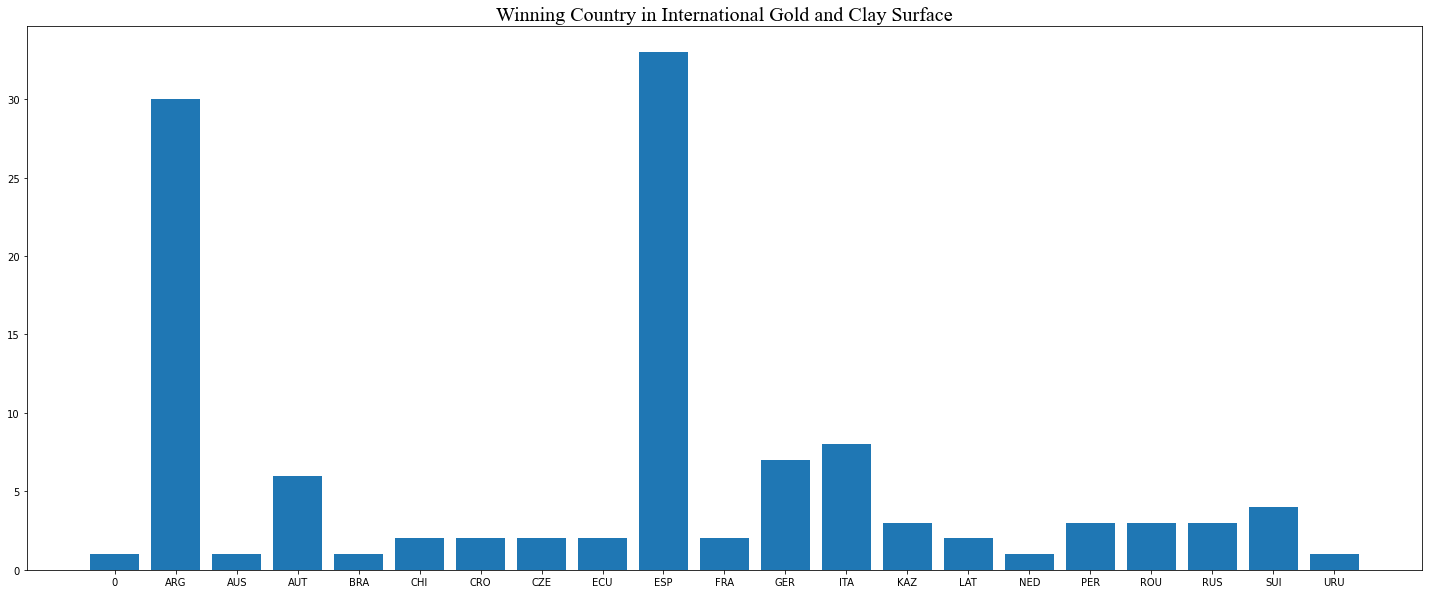

In [14]:
#5 dataframs

tournamentGoldClayData = tournamentData[["series","surface","location"]]
tournamentGoldClayWonData = tournamentWonData[["winner","wpts"]]
tournamentGoldClayWinnerData= tournamentWinnerData[["pl1_flag","pl1_hand","pl1_year_pro"]]
tournamentGoldClayLostData=tournamentLostData["Loser"]
tournamentGoldClayLoserData=tournamentLoserData["pl2_hand"]

# 5 dataframs concadination 

tableConcat=pd.concat([tournamentGoldClayData,tournamentGoldClayWonData,tournamentGoldClayWinnerData,tournamentGoldClayLostData,tournamentGoldClayLoserData], axis=1)

#conditions for International Gold and Clay Surface

GoldClayCondition=(tableConcat["series"]=='International Gold') & (tableConcat["surface"]=='Clay')
resultsGoldClay=tableConcat.loc[GoldClayCondition]

#To find the maximum winner in each country

NumberOfWinnerEachCounty= resultsGoldClay.groupby('pl1_flag')['winner'].count()

#Reset_index 
NumberOfWinnerEachCounty=NumberOfWinnerEachCounty.reset_index()

#Bar chart for each country in international gold series
plt.figure(figsize=(25,10))
plt.title('Winning Country in International Gold and Clay Surface',fontdict={'fontname': 'Times New Roman' ,'fontsize':20})

plt.bar(NumberOfWinnerEachCounty.pl1_flag,NumberOfWinnerEachCounty.winner)
plt.savefig('bar.png')
plt.show()




#topPlayers


topWinnerPlayersInEachCountry=tableConcat.sort_values(["pl1_flag","wpts"], ascending=False).groupby('pl1_flag').head(1)


NumberOfWinnerEachCounty

topWinnerPlayersInEachCountry.to_sql("rajeswari_da_11_2_result", migrateData, index=False, if_exists='replace')